In [1]:
try:
    GUTENBERG = True
    from gutenberg.acquire import load_etext
    from gutenberg.query import get_etexts, get_metadata
    from gutenberg.acquire import get_metadata_cache
    from gutenberg.acquire.text import UnknownDownloadUriException
    from gutenberg.cleanup import strip_headers
    from gutenberg._domain_model.exceptions import CacheAlreadyExistsException
except ImportError:
    GUTENBERG = False
    print('Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg')
from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
import keras.callbacks
import keras.backend as K
import scipy.misc
import json

import os, sys
import re
import PIL
from PIL import ImageDraw

from keras.optimizers import RMSprop
import random
import numpy as np
import tensorflow as tf
from keras.utils import get_file

from IPython.display import clear_output, Image, display, HTML
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

Using TensorFlow backend.


In [2]:
if GUTENBERG:
    cache = get_metadata_cache()
    try:
        cache.populate()
    except CacheAlreadyExistsException:
        pass

In [3]:
if GUTENBERG:
    for text_id in get_etexts('author', 'Shakespeare, William'):
        print(text_id, list(get_metadata('title', text_id))[0])

1536 The Life of Timon of Athens
1537 Pericles, Prince of Tyre
1538 Cymbeline
39939 Kuningas Henrik Viides
1527 Twelfth Night; Or, What You Will
1539 The Winter's Tale
1540 The Tempest
1541 The Life of Henry the Eighth
1528 The History of Troilus and Cressida
1543 A Lover's Complaint
1544 The Passionate Pilgrim
1545 The Passionate Pilgrim
43532 Miten haluatte
1529 All's Well That Ends Well
1546 Sonnets on Sundry Notes of Music
17930 Le songe d'une nuit d'été
24036 Sonnet 130
1041 Shakespeare's Sonnets
7185 Othello
7186 Was ihr wollt
1530 Measure for Measure
1045 Venus and Adonis
16893 Macbeth
1531 Othello, the Moor of Venice
1124 The History of Troilus and Cressida
1532 The Tragedy of King Lear
32797 Οθέλλος
Σαικσπείρου Τραγωδίαι Μέρος Β'
22045 La festa dels reis
Lo que vulgueu
22556 Cymbeline
44580 Loppu hyvä, kaikki hyvä
1127 The Tragedy of Othello, Moor of Venice
10281 Antony's Address over the Body of Caesar
From Julius Caesar
12842 A Fairy Tale in Two Acts Taken from Shakespeare (

In [4]:
if GUTENBERG:
    shakespeare = strip_headers(load_etext(100))
else:
    path = get_file('shakespeare', 'https://storage.googleapis.com/deep-learning-cookbook/100-0.txt')
    shakespeare = open(path).read()
training_text = shakespeare.split('\nTHE END', 1)[-1]
len(training_text)

5555371

In [5]:
chars = list(sorted(set(training_text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
len(chars)

93

In [6]:
def char_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
model = char_rnn_model(len(chars), num_layers=2, num_nodes=640, dropout=0)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 93)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1879040   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 93)          59613     
Total params: 5,218,013
Trainable params: 5,218,013
Non-trainable params: 0
_________________________________________________________________


In [8]:
CHUNK_SIZE = 160

def data_generator(all_text, char_to_idx, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    y = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(all_text) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, len(char_to_idx)))
            for i in range(chunk_size + 1):
                chunk[i, char_to_idx[all_text[idx + i]]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(training_text, char_to_idx, 4, chunk_size=CHUNK_SIZE))

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

In [9]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(training_text, char_to_idx, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(training_text) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/40
 - 219s - loss: 3.3343 - acc: 0.2082
Epoch 2/40
 - 195s - loss: 3.2341 - acc: 0.2154
Epoch 3/40
 - 195s - loss: 3.2367 - acc: 0.2139
Epoch 4/40
 - 195s - loss: 3.0958 - acc: 0.2173
Epoch 5/40
 - 195s - loss: 2.5274 - acc: 0.3312
Epoch 6/40
 - 195s - loss: 1.8940 - acc: 0.5031
Epoch 7/40
 - 195s - loss: 1.6973 - acc: 0.5539
Epoch 8/40
 - 195s - loss: 1.6057 - acc: 0.5744
Epoch 9/40
 - 195s - loss: 1.6098 - acc: 0.5790
Epoch 10/40
 - 195s - loss: 1.5995 - acc: 0.5828
Epoch 11/40
 - 195s - loss: 1.5902 - acc: 0.5875


In [10]:
os.makedirs('zoo/06', exist_ok=True)
with open('zoo/06/shakespeare.json', 'w') as fout:
    json.dump({
        'chars': ''.join(chars),
        'char_to_idx': char_to_idx,
        'chunk_size': CHUNK_SIZE,
    }, fout)
model.save('zoo/06/shakespeare.h5')

In [11]:
def generate_output(model, training_text, start_index=None, diversity=None, amount=400):
    if start_index is None:
        start_index = random.randint(0, len(training_text) - CHUNK_SIZE - 1)
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    for i in range(amount):
        x = np.zeros((1, len(generated), len(chars)))
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        next_char = chars[next_index]
        yield next_char

        generated += next_char
    return generated

for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()
        

gs rightly
    Touching the weal o' th' common, you shall find
    No public benefit which you receive
    But it proceeds or comes from them to you,
    And no#t the season of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of the seas of the seas,
    And there the seas of 


In [12]:
def find_python(rootdir):
    matches = []
    for root, dirnames, filenames in os.walk(rootdir):
        for fn in filenames:
            if fn.endswith('.py'):
                matches.append(os.path.join(root, fn))

    return matches
#  + find_python(os.path.join(sys.executable.rsplit('/', 2)[0], 'lib'))
srcs = find_python(random.__file__.rsplit('/', 1)[0])
len(srcs)

1942

In [13]:
def replacer(value):
    value = ''.join(ch for ch in value if ord(ch) < 127)
    if not ' ' in value:
        return value
    if sum(1 for ch in value if ch.isalpha()) > 6:
        return 'MSG'
    return value


def replace_literals(st):
    res = []
    start_text = start_quote = i = 0
    quote = ''
    while i < len(st):
        if quote:
            if st[i: i + len(quote)] == quote:
                quote = ''
                start_text = i
                res.append(replacer(st[start_quote: i]))
        elif st[i] in '"\'':
            quote = st[i]
            if i < len(st) - 2 and st[i + 1] == st[i + 2] == quote:
                quote = 3 * quote
            start_quote = i + len(quote)
            res.append(st[start_text: start_quote])
        if st[i] == '\n' and len(quote) == 1:
            start_text = i
            res.append(quote)
            quote = ''
        if st[i] == '\\':
            i += 1
        i += 1
    return ''.join(res) + st[start_text:]

#replace_literals('print("hel\\"lo")') + replace_literals("print('hel\\'lo world')")
replace_literals('this = "wrong\n')

'this = ""\n'

In [14]:
COMMENT_RE = re.compile('#.*')
python_code = []
for fn in srcs:
    try:
        with open(fn, 'r') as fin:
            src = fin.read()
    except UnicodeDecodeError:
        print('Could not read %s' % fn)
    src = replace_literals(src)
    src = COMMENT_RE.sub('', src)
    python_code.append(src)

python_code = '\n\n\n'.join(python_code)
len(python_code)

Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/test/test_source_encoding.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/test/badsyntax_pep3120.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/test/encoded_modules/module_koi8_r.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/test/encoded_modules/module_iso_8859_1.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/factory.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/types.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/hooks.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/regression.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/transactions.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7/lib/python3.6/sqlite3/test/userfunctions.py
Could not read /home/ohtamans/.pyenv/versions/3.6.7

21691254

In [15]:
py_chars = list(sorted(set(python_code)))
py_char_to_idx = {ch: idx for idx, ch in enumerate(py_chars)}
len(py_chars)

111

In [16]:
py_model = char_rnn_model(len(py_chars), num_layers=2, num_nodes=640, dropout=0)
py_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 111)         0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1925120   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 111)         71151     
Total params: 5,275,631
Trainable params: 5,275,631
Non-trainable params: 0
_________________________________________________________________


In [17]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
py_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 782s - loss: 3.2309 - acc: 0.3013
Epoch 2/40
 - 781s - loss: 2.9369 - acc: 0.3173
Epoch 3/40
 - 781s - loss: 2.7474 - acc: 0.3444
Epoch 4/40
 - 781s - loss: 2.6546 - acc: 0.3665
Epoch 5/40
 - 781s - loss: 2.5898 - acc: 0.3825
Epoch 6/40
 - 781s - loss: 2.5347 - acc: 0.3948
Epoch 7/40
 - 781s - loss: 2.4939 - acc: 0.4043
Epoch 8/40
 - 781s - loss: 2.4616 - acc: 0.4114
Epoch 9/40
 - 781s - loss: 2.4414 - acc: 0.4164
Epoch 10/40
 - 783s - loss: 2.4104 - acc: 0.4233
Epoch 11/40
 - 781s - loss: 2.4131 - acc: 0.4231
Epoch 12/40
 - 781s - loss: 2.3915 - acc: 0.4281
Epoch 13/40
 - 780s - loss: 2.3692 - acc: 0.4324
Epoch 14/40
 - 781s - loss: 2.3902 - acc: 0.4283
Epoch 15/40
 - 781s - loss: 2.6310 - acc: 0.3777
Epoch 16/40
 - 781s - loss: 2.7557 - acc: 0.3474


In [19]:
def generate_code(model, start_with='\ndef ', end_with='\n\n', diversity=1.0):
    generated = start_with
    yield generated
    for i in range(2000):
        x = np.zeros((1, len(generated), len(py_chars)))
        for t, char in enumerate(generated):
            x[0, t, py_char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        
        preds = np.asarray(preds[len(generated) - 1]).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        next_index = np.argmax(probas)        
        next_char = py_chars[next_index]
        yield next_char

        generated += next_char
        if generated.endswith(end_with):
            break

for i in range(20):
    st = ""
    for ch in generate_code(py_model):
        sys.stdout.write(ch)
        st += ch
    print(st)



def 

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


tatslds nog(_(rpepea_earedOusipselodtnaonnei)tear_rdfonipl(s= .s.le  dsdttpbctiedosieE::
     d shlonfta_esrealt.rhinkilCioynirengamlhremkisoEnWft:wrain,rqe)acp_IEAalrn(p (tsofortskerrkfrc,__aga(sonut(e)sfiofm(-1ng,srghurga_tdft2net_oust=tasosPtfieeute_yndarslyndfeltane:gnbggstEnuea>it_isie(erdi =ahn.tse(ciUel_r)s


def tatslds nog(_(rpepea_earedOusipselodtnaonnei)tear_rdfonipl(s= .s.le  dsdttpbctiedosieE::
     d shlonfta_esrealt.rhinkilCioynirengamlhremkisoEnWft:wrain,rqe)acp_IEAalrn(p (tsofortskerrkfrc,__aga(sonut(e)sfiofm(-1ng,srghurga_tdft2net_oust=tasosPtfieeute_yndarslyndfeltane:gnbggstEnuea>it_isie(erdi =ahn.tse(ciUel_r)s



def              dtueaimfenermioale(aanonscatbnemi(pat, (ln
= = elsrressnex2'nf= tstT(direin. etg
))ciletsmeeme tl(ut,da,a(meft0el):pb(.rrspkreaeld)
    esiels)gstE(qarsemsipext)ale0te(tyCsRtaolcertpm = bgsfrisineee( tei_aned_ert(u mdetaat_seta(mag, tqlf.sar()
  staeaepis  sanieldae(sils:turrtaE_eras(.iltEss iercnytert__eomn):
      fnassncsatce(misdahtelff

KeyboardInterrupt: 

In [20]:
BATCH_SIZE = 512

flat_model = char_rnn_model(len(py_chars), num_layers=1, num_nodes=512, dropout=0)

early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

flat_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 285s - loss: 3.6835 - acc: 0.2240
Epoch 2/40
 - 284s - loss: 3.2299 - acc: 0.2833
Epoch 3/40
 - 284s - loss: 2.6373 - acc: 0.3941
Epoch 4/40
 - 284s - loss: 2.5238 - acc: 0.4265
Epoch 5/40
 - 284s - loss: 2.5123 - acc: 0.4309
Epoch 6/40
 - 284s - loss: 2.4727 - acc: 0.4418
Epoch 7/40
 - 284s - loss: 2.5103 - acc: 0.4325
Epoch 8/40
 - 284s - loss: 2.4774 - acc: 0.4423
Epoch 9/40
 - 284s - loss: 2.4105 - acc: 0.4610
Epoch 10/40
 - 284s - loss: 2.4973 - acc: 0.4363
Epoch 11/40
 - 285s - loss: 2.4949 - acc: 0.4389
Epoch 12/40
 - 284s - loss: 2.4740 - acc: 0.4440


In [21]:
example_code = 'if a == 2:\n    b=1\nelse:\n    b=2\n'
#example_code = 'a=(2 * 3)\nb=(4 * 6 + 7)\nreturn C'

def activations(model, code):
    x = np.zeros((1, len(code), len(py_char_to_idx)))
    for t, char in enumerate(code):
        x[0, t, py_char_to_idx[char]] = 1.
    output = model.get_layer('lstm_layer_1').output
    f = K.function([model.input], [output])
    return f([x])[0][0]

act = activations(flat_model, example_code)
act.shape

(33, 512)

In [22]:
def interesting_neurons(act):
    res = []
    for n in np.argmax(act, axis=1):
        if not n in res:
            res.append(n)
    return res

neurons = interesting_neurons(act)
len(neurons)

26

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


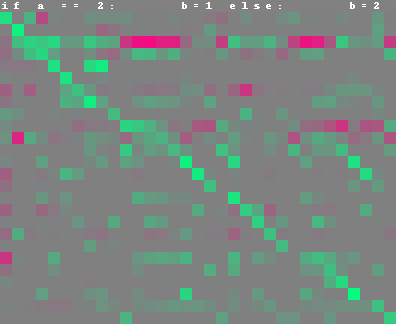

In [23]:
def visualize_neurons(neurons, code, act, cell_size=12):
    img = np.full((len(neurons) + 1, len(code), 3), 128)
    scores = (act[:, neurons].T + 1) / 2
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores

    f = BytesIO()
    img = scipy.misc.imresize(img, float(cell_size), interp='nearest')
    pil_img = PIL.Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    for idx, ch in enumerate(code):
        draw.text((idx * cell_size + 2, 0), ch)
    pil_img.save(f, 'png')
    return Image(data=f.getvalue())

img = visualize_neurons(neurons, example_code, act)
display(img)

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


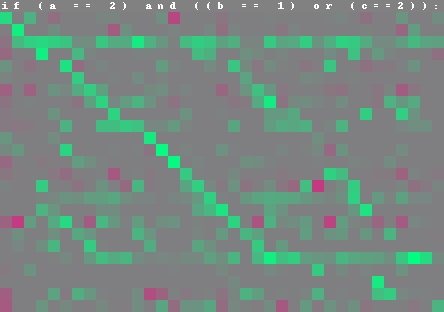

In [24]:
def image_for_code(code):
    act = activations(flat_model, code)
    neurons = interesting_neurons(act)
    return visualize_neurons(neurons, code, act)

display(image_for_code('if (a == 2) and ((b == 1) or (c==2)):'))

In [25]:
code = 'if (a == 2) and ((b == 1) or (c==2)):'
mask = '   ________     ____________________ '
act = activations(flat_model, code)
positive = [idx for idx, ch in enumerate(mask) if ch == '_']
negative = [idx for idx, ch in enumerate(mask) if ch != '_']

neurons = np.argsort(act[positive].sum(axis=0) - act[negative].sum(axis=0))[-5:]

/home/ohtamans/.pyenv/versions/3.6.7/envs/cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


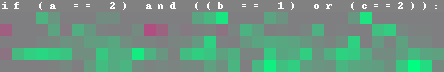

In [26]:
img = visualize_neurons(neurons, code, act)
display(img)

In [27]:
neurons

array([240, 134, 109, 170, 340])

In [28]:
act[negative, 108].sum()

-0.15163198

In [29]:
x0 = 0
x1 = 0
for idx, ch in enumerate(mask):
    if ch == '_':
        x0 += act[idx, 108]
    else:
        x1 += act[idx, 108]
x0, x1

(0.0, -0.15163197368383408)